<a href="https://colab.research.google.com/github/vincenzobucciero/mySegmentAnything/blob/main/maskGenerator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Mon Apr 22 21:05:48 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


In [3]:
#install segment anything model
!pip install -q 'git+https://github.com/facebookresearch/segment-anything.git'

  Preparing metadata (setup.py) ... done


In [4]:
# download SAM WEIGHTS
!mkdir -p {HOME}/weights
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -P {HOME}/weights

In [5]:
!pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.8/367.8 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.1/74.1 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.1/97.1 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 49.3 MB/s eta 0:00:00


In [6]:
import os

CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

/content/weights/sam_vit_h_4b8939.pth ; exist: True


In [7]:
# create dir videoTest
!mkdir -p {HOME}/data/videoTest

In [8]:
# load model
import torch

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

In [14]:
# mask generator

# automated mask generator
# To run automatic mask generation, provide a SAM model to the SamAutomaticMaskGenerator class. Set the path below to the SAM checkpoint
mask_generator = SamAutomaticMaskGenerator(sam)

# sam_result = mask_generator.generate(image_rgb)

import cv2
import os
from google.colab.patches import cv2_imshow

# VIDEO_NAME e VIDEO_PATH
VIDEO_NAME = "manythings.mp4"  # file intero
VIDEO_PATH = os.path.join(HOME, "data/videoTest", VIDEO_NAME)

# Numero massimo di frame da elaborare
max_frames = 9999

# Invece di leggere un'immagine, leggi il video
cap = cv2.VideoCapture(VIDEO_PATH)

# Ciclo per elaborare ciascun frame del video
frame_count = 0
while cap.isOpened() and frame_count < max_frames:
    # Leggi il frame corrente
    ret, frame = cap.read()

    # Controlla se il frame è stato letto correttamente
    if ret:
        # Mostra il frame
        # cv2_imshow(frame)

        # Incrementa il conteggio dei frame
        frame_count += 1
    else:
        break

print("Numero di frame estratti : ", frame_count)

Numero di frame estratti :  1167


In [13]:
# rle encoding
from itertools import groupby

def mask_to_rle(m, maxstride=100000000):
    # reshape mask to vector
    v = m.reshape((m.shape[0] * m.shape[1]))

    if v.size == 0:
        return [0]

    # output is empty at the beginning
    rle = []
    # index of the last different element
    last_idx = 0
    # check if first element is 1, so first element in RLE (number of zeros) must be set to 0
    if v[0] > 0:
        rle.append(0)

    # go over all elements and check if two consecutive are the same
    for i in range(1, v.size):
        if v[i] != v[i - 1]:
            length = i - last_idx
            # if length is larger than maxstride, split it into multiple elements
            while length > maxstride:
                rle.append(maxstride)
                rle.append(0)
                length -= maxstride
            # add remaining length
            if length > 0:
                rle.append(length)
            last_idx = i

    if v.size > 0:
        # handle last element of rle
        if last_idx < v.size - 1:
            # last element is the same as one element before it - add number of these last elements
            length = v.size - last_idx
            while length > maxstride:
                rle.append(maxstride)
                rle.append(0)
                length -= maxstride
            if length > 0:
                rle.append(length)
        else:
            # last element is different than one element before - add 1
            rle.append(1)
    return rle

frames per second = 29.97
frame id: 457


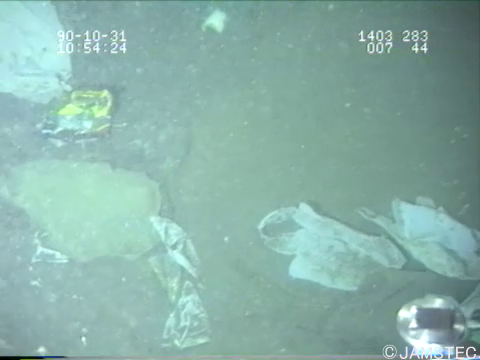

Numero di maschere totali nel frame trovate: 52


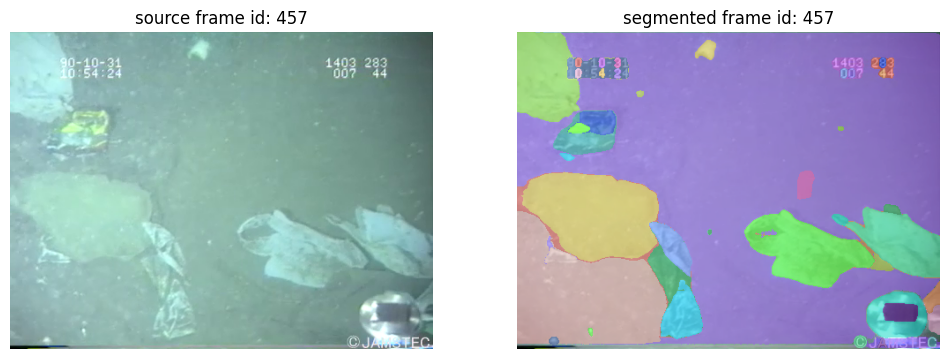

In [162]:
from google.colab import files
import cv2
import numpy as np
import random
import math
import matplotlib.pyplot as plt

# PROCEDURA PER ESTRARRE UN DETERMINATO FRAME
fps = cap.get(cv2.CAP_PROP_FPS)
print('frames per second =',fps)

minutes = 0
seconds = 15.25

frame_id = int(fps*(minutes*60 + seconds))
print('frame id: ' f"{frame_id}")

cap.set(cv2.CAP_PROP_POS_FRAMES, frame_id)
ret, frame = cap.read()

if ret:
    cv2_imshow(frame)

    sam_result = mask_generator.generate(frame)
else:
    print("Error: Unable to read frame from the video.")


print("Numero di maschere totali nel frame trovate:", len(sam_result))

# Results visualisation with Supervision
import supervision as sv
import matplotlib.pyplot as plt
import numpy as np

mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections.from_sam(sam_result=sam_result)

annotated_frame = mask_annotator.annotate(scene=frame.copy(), detections=detections)

sv.plot_images_grid(
    images=[frame, annotated_frame],
    grid_size=(1, 2),
    titles=['source frame id: ' f"{frame_id}", 'segmented frame id: ' f"{frame_id}"]
)

def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0

    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

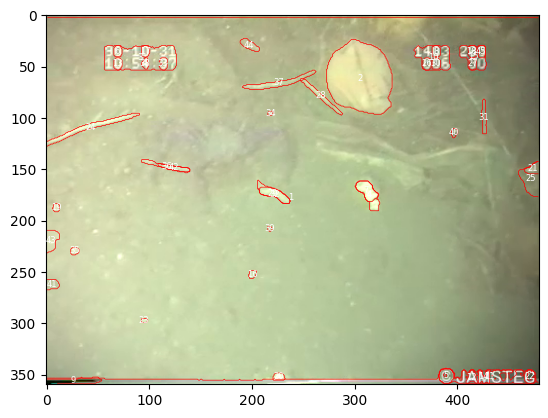

In [57]:

start_id = 1
# Apre il file "encodingRLE" in modalità scrittura
with open("encodingRLE.txt", "w") as file:
    file.write(f"MASCHERE RELATIVE AL FRAME {frame_id}\n")
    # Itera su ogni risultato di SAM
    for mask_id, result in enumerate(sam_result, start = start_id):
        # Calcola la codifica RLE per la maschera corrente
        rle_encoding = mask_to_rle(result['segmentation'])

        # Scrive l'ID della maschera e la relativa codifica RLE nel file
        file.write(f"Maschera id [{mask_id}] -> RLE: {rle_encoding}\n")


######

import matplotlib.pyplot as plt
import numpy as np

# Funzione per visualizzare gli ID delle maschere quando si passa sopra con il mouse
def show_masks_with_ids(frame, sam_result):
    # Creazione di una figura e di un'area di plot
    fig, ax = plt.subplots()
    ax.imshow(frame)

    # Iterazione sui risultati SAM per disegnare i contorni delle maschere e visualizzare gli ID
    for mask_id, result in enumerate(sam_result, start=1):
        mask = result['segmentation']
        # Disegna il contorno della maschera
        ax.contour(mask, colors=[(1, 0, 0)], linewidths=0.5)

        # Calcola il centroide della maschera
        y, x = np.where(mask)
        centroid_x = np.mean(x).astype(int)
        centroid_y = np.mean(y).astype(int)

        # Visualizza l'ID della maschera vicino al suo centroide
        ax.text(centroid_x, centroid_y, str(mask_id), color='white', fontsize=6, ha='center', va='center')

    # Funzione per aggiornare la visualizzazione quando si passa sopra con il mouse
    def hover(event):
        if event.inaxes == ax:
            ax.figure.canvas.draw()

    # Connessione dell'evento di movimento del mouse alla funzione hover
    fig.canvas.mpl_connect('motion_notify_event', hover)

    plt.show()

# Utilizzo della funzione per visualizzare gli ID delle maschere sul frame
show_masks_with_ids(frame, sam_result)
